In [1]:
import xarray as xr
import rioxarray as rio
from utils import *
from typing import Tuple
from glob import glob
from tqdm import tqdm

# Preform a sensitivity analysis to remote sensing data saturation at high biomass densities

## 1. Introduction

One possible bias in remote sensing data is the saturation of the signal at high biomass densities. This means that in dense forests, we will not be able to detect small but persistent growth in living biomass. 

To test the impact of such a bias, we perform a sensitivity analysis according to the method used in [Xu et al. (2021)](https://www.science.org/doi/10.1126/sciadv.abe9829). We apply this method to gridded datasets that report absolute biomass densities. These are:
1. Xu et al.

2. Liu et al.

3. Chen et al.

4. L-VOD data

### 1.1 Methodology summary

The approach applies a biomass density cutoff to define a "dense forest", and then applies a constant growth rate to the biomass density in these forests. 

The growth rates are taken from Table S4 of [Xu et al. (2021)](https://www.science.org/doi/10.1126/sciadv.abe9829) and are defined for different ecosystems.

To take into account disturbance in dense forests, the method calculates the area impacted by disturbance in dense forests per year. The growth rates are applied only to areas which have not been disturbed. 

We calculate the fraction of disturbed area using the following approach. Xu et al. report the total emissions from deforestation $E_C$, forest degradation $E_{FD}$, and fire in forests and nonforests $E_{Fire}$. As reported in Xu et al., the way these emissions are calculated is (for example for forest degradation):

$$E_{FD_i}=PDA_i \times C_i \times f_D$$

Where $PDA_i$ is the proportion of disturbed area in grid cell $i$, $C_i$ is the carbon density in grid cell $i$, and $f_D$ is the fraction of carbon loss per grid cell due to forest degradation.

This means that we can calculate from the emissions $E_{FD_i}$ the proportion of disturbed area in each grid cell $PDA_i$ using the following equation:
$$PDA_i = \frac{E_{FD_i}}{C_i \times f_D}$$

This is an example for forest degregation, but the same holds for PCA and PBA.

## 2. Load data

In [2]:
# biomass stocks data
xu_data = rio.open_rasterio('../data/biomass/xu_et_al_2021/test10a_cd_ab_pred_corr_2000_2019_v2.tif')
xu_data['time'] = xu_data.time.dt.year

# emissions from disturbance data
fire_data = rio.open_rasterio('../data/land_cover/xu_et_al_2021/fireforest_emission_0119_v2_inTg.tif',masked=True).rename({'band':'time'})
fire_nonforest_data = rio.open_rasterio('../data/land_cover/xu_et_al_2021/firenonforest_emission_0119_v2_inTg.tif',masked=True).rename({'band':'time'})
deforestation_data = rio.open_rasterio('../data/land_cover/xu_et_al_2021/deforestation_emission_0119_v2_inTg.tif',masked=True).rename({'band':'time'})
degradation_data = rio.open_rasterio('../data/land_cover/xu_et_al_2021/degradation_emission_0119_v2_inTg.tif',masked=True).rename({'band':'time'})

# region definitions for growth rates
xu_regions = rio.open_rasterio('../data/regions_data/xu_et_al_2021/global_ecoregions.tif').sel(band=1)

# replace regions 0,15, and 16 with NaN and convert values to start from 0
xu_regions = xr.where(xu_regions.isin([0,15,16]),np.nan,xu_regions-101)
xu_regions.rio.write_crs('EPSG:4326',inplace=True);


# growth rate data for mature forests
growth_rates = pd.read_csv('../data/biomass/xu_et_al_2021/table_s4.csv')

# set up a map of growth rates
growth_rate_map = xr.zeros_like(xu_data[0,:,:])

# set growth rates for each region
regional_growth_rate = -1*np.concatenate([growth_rates.set_index('code')['Growth rate [Mg/ha/yr]'].values,np.array([np.nan])])

# fill in the values in the growth rate map based on the regional_growth_rate indices
growth_rate_map.data = regional_growth_rate[xu_regions.fillna(growth_rates.shape[0]).values.astype(int)]

## 3. Define functions for analysis

In [3]:
def analyze_dataset_old(ds:xr.DataArray, growth_rate_map:xr.DataArray, disturbances:xr.DataArray)->Tuple[xr.DataArray,xr.DataArray]:
    """
    This function calculates the total biomass stocks assuming that "dense forests" (defined according to two thresholds - 100 and 200 Mg/ha) are growing at a constant rate.
    The growth rates are defined in the `growth_rate_map` variable. 
    From the base growth rate, we remove area that was affected by disturbance, defined by the `disturbances` varaible.
    
    Parameters:
    ds (xr.DataArray): the dataset containing the biomass stocks
    growth_rate_map (xr.DataArray): the map of growth rates
    disturbances (xr.DataArray): the map of disturbances

    Returns:
    (xr.DataArray,xr.DataArray): the biomass stocks in dense forests for the 100 Mg/ha and 200 Mg/ha thresholds
    """
    

    # define the mask for the 100 and 200 Mg/ha thresholds for "dense forests"
    mask_200 = ds.where(ds.sum(dim='landcover')>200)
    mask_100 = ds.where(ds.sum(dim='landcover')>100)

    # define the base map for the growth rates
    base_map = xr.zeros_like(ds.sel(time=ds['time'].values[0]))

    # reproject the growth rate map and disturbances to match the dataset
    gm = growth_rate_map.rio.reproject_match(ds)
    dist_map = disturbances.rio.reproject_match(ds)

    # fill in missing years in the disturbance map
    missing_years = list(set(ds['time'].values).difference(set(dist_map['time'].values)))
    if len(missing_years)>0:
        dist_map = xr.concat([dist_map,dist_map.interp(time=missing_years)],dim='time').sortby('time')
        dist_map = dist_map.bfill('time')

    # calculate the biomass accumulated in undisturbed dense forests
    intact_changes = xr.concat([base_map+gm*i for i in (ds['time']-ds['time'][0]).values],dim='time').transpose('landcover','time','y','x')
    intact_changes['time'] = ds['time']

    # apply the growth rates to the forest and nonforest fractions of the map based on their relative biomass contribution
    intact_changes = intact_changes*(ds/ds.sum(dim='landcover'))

    # remove from the "dense forests" the area fraction lost to disturbances
    intact_changes_disturbances = intact_changes.copy()
    intact_changes_disturbances[:,1:,:,:] = intact_changes_disturbances[:,1:,:,:]*(1-dist_map.fillna(0))

    # calculate the "dense forest" biomass using the stocks from the first year and the accumulated biomass
    mask_h200_stocks = (intact_changes_disturbances + mask_200.sel(time=mask_200['time'].values[0]))
    mask_h100_stocks = (intact_changes_disturbances + mask_100.sel(time=mask_100['time'].values[0]))

    # define the "non dense forest" biomass
    mask_l200_stocks = ds.where(ds.sel(time=ds['time'].values[0]).sum(dim='landcover')<200)
    mask_l100_stocks = ds.where(ds.sel(time=ds['time'].values[0]).sum(dim='landcover')<100)

    # sum the "dense" and "non dense" forest biomass
    merged_100 = (mask_h100_stocks.fillna(0) + mask_l100_stocks.fillna(0)) + (ds-ds)
    merged_200 = (mask_h200_stocks.fillna(0) + mask_l200_stocks.fillna(0)) + (ds-ds)

    
    return merged_100,merged_200

In [4]:
def analyze_dataset(ds:xr.DataArray, growth_rate_map:xr.DataArray, disturbances:xr.DataArray)->Tuple[xr.DataArray,xr.DataArray]:
    """
    This function calculates the total biomass stocks assuming that "dense forests" (defined according to two thresholds - 100 and 200 Mg/ha) are growing at a constant rate.
    The growth rates are defined in the `growth_rate_map` variable. 
    From the base growth rate, we remove area that was affected by disturbance, defined by the `disturbances` varaible.
    
    Parameters:
    ds (xr.DataArray): the dataset containing the biomass stocks
    growth_rate_map (xr.DataArray): the map of growth rates
    disturbances (xr.DataArray): the map of disturbances

    Returns:
    (xr.DataArray,xr.DataArray): the biomass stocks in dense forests for the 100 Mg/ha and 200 Mg/ha thresholds
    """
    

    # define the base map for the growth rates
    base_map = xr.zeros_like(ds.sel(time=ds['time'].values[0]))

    # reproject the growth rate map and disturbances to match the dataset
    gm = growth_rate_map.rio.reproject_match(ds)
    dist_map = disturbances.rio.reproject_match(ds)

    # fill in missing years in the disturbance map
    missing_years = list(set(ds['time'].values).difference(set(dist_map['time'].values)))
    if len(missing_years)>0:
        dist_map = xr.concat([dist_map,dist_map.interp(time=missing_years)],dim='time').sortby('time')
        dist_map = dist_map.bfill('time')

    # calculate the biomass accumulated in undisturbed dense forests
    intact_changes = xr.concat([base_map+gm*i for i in (ds['time']-ds['time'][0]).values],dim='time').transpose('landcover','time','y','x')
    intact_changes['time'] = ds['time']

    # apply the growth rates to the forest and nonforest fractions of the map based on their relative biomass contribution
    intact_changes = intact_changes*(ds/ds.sum(dim='landcover'))

    # remove from the "dense forests" the area fraction lost to disturbances
    intact_changes_disturbances = intact_changes.copy()
    intact_changes_disturbances[:,1:,:,:] = intact_changes_disturbances[:,1:,:,:]*(1-dist_map.fillna(0))

    # add the "dense forest" growth to the data
    merged_100  = (intact_changes_disturbances.where(ds.sum(dim='landcover')>100).fillna(0) + ds)
    merged_200  = (intact_changes_disturbances.where(ds.sum(dim='landcover')>200).fillna(0) + ds)
    
    # drop zero values
    merged_100 = merged_100.where(merged_100!=0)
    merged_200 = merged_200.where(merged_200!=0)
    
    return merged_100,merged_200



In [5]:
def analyze_dataset_new(ds:xr.DataArray, growth_rate_map:xr.DataArray, disturbances:xr.DataArray)->Tuple[xr.DataArray,xr.DataArray]:
    """
    This function calculates the total biomass stocks assuming that "dense forests" (defined according to two thresholds - 100 and 200 Mg/ha) are growing at a constant rate.
    The growth rates are defined in the `growth_rate_map` variable. 
    From the base growth rate, we remove area that was affected by disturbance, defined by the `disturbances` varaible.
    
    Parameters:
    ds (xr.DataArray): the dataset containing the biomass stocks
    growth_rate_map (xr.DataArray): the map of growth rates
    disturbances (xr.DataArray): the map of disturbances

    Returns:
    (xr.DataArray,xr.DataArray): the biomass stocks in dense forests for the 100 Mg/ha and 200 Mg/ha thresholds
    """
    

    base_map = xr.zeros_like(ds.sel(time=ds['time'].values[0]))

    # reproject the growth rate map and disturbances to match the dataset
    gm = growth_rate_map.rio.reproject_match(ds)
    dist_map = disturbances.rio.reproject_match(ds)

    # fill in missing years in the disturbance map
    missing_years = list(set(ds['time'].values).difference(set(dist_map['time'].values)))
    if len(missing_years)>0:
        dist_map = xr.concat([dist_map,dist_map.interp(time=missing_years)],dim='time').sortby('time')
        dist_map = dist_map.bfill('time')

    # calculate the biomass accumulated in undisturbed dense forests
    intact_changes = xr.concat([base_map+gm*i for i in (ds['time']-ds['time'][0]).values],dim='time').transpose('landcover','time','y','x')
    intact_changes['time'] = ds['time']

    # apply the growth rates to the forest and nonforest fractions of the map based on their relative biomass contribution
    intact_changes = intact_changes*(ds/ds.sum(dim='landcover'))

    # remove from the "dense forests" the area fraction lost to disturbances
    intact_changes_disturbances = intact_changes.copy()
    intact_changes_disturbances[:,1:,:,:] = intact_changes_disturbances[:,1:,:,:]*(1-dist_map.fillna(0))

    
    # sum the "dense" and "non dense" forest biomass
    merged_100 = intact_changes_disturbances.where(ds.sum(dim='landcover')>100)+ds
    merged_200 = intact_changes_disturbances.where(ds.sum(dim='landcover')>200)+ds

    
    return merged_100,merged_200

## 4. Run analysis

In [6]:
# convert total emissions (TgC/yr) to densities (MgC/ha/yr)
def convert_emissions_to_density(da):
     da = da*1e12/calc_pixel_area(da)/100
     da['time'] = xu_data['time'][1:]
     return da

# calculate the emission density for each type of disturbance
fire_density = convert_emissions_to_density(fire_data.fillna(0)+fire_nonforest_data.fillna(0))
deforestation_density = convert_emissions_to_density(deforestation_data)
degradation_density = convert_emissions_to_density(degradation_data)

# factors from Xu et al.
f_D = 0.07
f_B = 0.3
f_C = 1

# calculate the area affected according to the equation presented in the introduction
PDA = (degradation_density/xu_data/f_D).fillna(0)
PCA = (deforestation_density/xu_data/f_C).fillna(0)
PBA = (fire_density/xu_data/f_B).fillna(0)

# sum all disturbances and make sure they are not greater than 1
disturbances = PDA+PCA+PBA
disturbances = xr.where(disturbances>1,1,disturbances)
disturbances.rio.write_crs('EPSG:4326',inplace=True);

In [123]:
# ds =xr.open_dataarray('../results/02_convert_AGB_TB/liu_biomass_CCI_ma_TB.nc',decode_times=False)
ds =xr.open_dataarray('../results/02_convert_AGB_TB/LVODmax_song_ma_TB.nc',decode_times=False)


# define the mask for the 100 and 200 Mg/ha thresholds for "dense forests"
mask_200 = ds.where(ds.sum(dim='landcover')>200)
mask_100 = ds.where(ds.sum(dim='landcover')>100)

# define the base map for the growth rates
base_map = xr.zeros_like(ds.sel(time=ds['time'].values[0]))

# reproject the growth rate map and disturbances to match the dataset
gm = growth_rate_map.rio.reproject_match(ds)
dist_map = disturbances.rio.reproject_match(ds)

# fill in missing years in the disturbance map
missing_years = list(set(ds['time'].values).difference(set(dist_map['time'].values)))
if len(missing_years)>0:
    dist_map = xr.concat([dist_map,dist_map.interp(time=missing_years)],dim='time').sortby('time')
    dist_map = dist_map.bfill('time')

# calculate the biomass accumulated in undisturbed dense forests
intact_changes = xr.concat([base_map+gm*i for i in (ds['time']-ds['time'][0]).values],dim='time').transpose('landcover','time','y','x')
intact_changes['time'] = ds['time']

# apply the growth rates to the forest and nonforest fractions of the map based on their relative biomass contribution
intact_changes = intact_changes*(ds/ds.sum(dim='landcover'))

# remove from the "dense forests" the area fraction lost to disturbances
intact_changes_disturbances = intact_changes.copy()
intact_changes_disturbances[:,1:,:,:] = intact_changes_disturbances[:,1:,:,:]*(1-dist_map.fillna(0))

# calculate the "dense forest" biomass using the stocks from the first year and the accumulated biomass
mask_h200_stocks = (intact_changes_disturbances + mask_200.sel(time=mask_200['time'].values[0]))
mask_h100_stocks = (intact_changes_disturbances + mask_100.sel(time=mask_100['time'].values[0]))

# define the "non dense forest" biomass
mask_l200_stocks = ds.where(ds.sel(time=ds['time'].values[0]).sum(dim='landcover')<200)
mask_l100_stocks = ds.where(ds.sel(time=ds['time'].values[0]).sum(dim='landcover')<100)

# sum the "dense" and "non dense" forest biomass
merged_100 = (mask_h100_stocks.fillna(0) + mask_l100_stocks.fillna(0)) + (ds-ds)
merged_200 = (mask_h200_stocks.fillna(0) + mask_l200_stocks.fillna(0)) + (ds-ds)


In [126]:
k4 = (intact_changes_disturbances.where(ds.sum(dim='landcover')>100).fillna(0) + ds).sum(dim='landcover')
(100*k4*calc_area(k4)).sum(dim=['x','y']).diff('time').mean()/9e15
# k4[0,:,:].plot()

<xarray.DataArray ()> Size: 8B
array(1.72870505)
Coordinates:
    method                          <U15 60B 'AGC_ASC_DESCmax'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [127]:
k3 = merged_100.sum(dim='landcover')
(100*k3*calc_area(k3)).sum(dim=['x','y']).diff('time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(1.94480709)
Coordinates:
    method                          <U15 60B 'AGC_ASC_DESCmax'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [82]:
ds =xr.open_dataarray('../results/02_convert_AGB_TB/liu_biomass_CCI_ma_TB.nc',decode_times=False)


# define the mask for the 100 and 200 Mg/ha thresholds for "dense forests"
mask_200 = ds.where(ds.sum(dim='landcover')>200)
mask_100 = ds.where(ds.sum(dim='landcover')>100)

# define the base map for the growth rates
base_map = xr.zeros_like(ds.sel(time=ds['time'].values[0]))

# reproject the growth rate map and disturbances to match the dataset
gm = growth_rate_map.rio.reproject_match(ds)
dist_map = disturbances.rio.reproject_match(ds)

# fill in missing years in the disturbance map
missing_years = list(set(ds['time'].values).difference(set(dist_map['time'].values)))
if len(missing_years)>0:
    dist_map = xr.concat([dist_map,dist_map.interp(time=missing_years)],dim='time').sortby('time')
    dist_map = dist_map.bfill('time')

# calculate the biomass accumulated in undisturbed dense forests
intact_changes = xr.concat([base_map+gm*i for i in (ds['time']-ds['time'][0]).values],dim='time').transpose('landcover','time','y','x')
intact_changes['time'] = ds['time']

# apply the growth rates to the forest and nonforest fractions of the map based on their relative biomass contribution
# intact_changes = intact_changes*(ds/ds.sum(dim='landcover'))

# remove from the "dense forests" the area fraction lost to disturbances
intact_changes_disturbances = intact_changes.copy()
intact_changes_disturbances[:,1:,:,:] = intact_changes_disturbances[:,1:,:,:]*(1-dist_map.fillna(0))


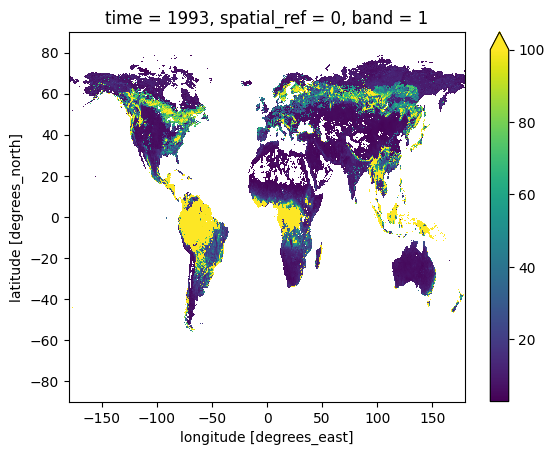

In [100]:
k2 = ds.sum(dim='landcover')
k2[0,:,:].where(k2[0,:,:]>0).plot(vmax=100)

In [106]:
(100*k2*calc_area(k2)).sum(dim=['x','y']).diff(dim='time').mean()

<xarray.DataArray ()> Size: 8B
array(-1.35389171e+14)
Coordinates:
    spatial_ref  int64 8B 0
    band         int64 8B ...

In [110]:
k = intact_changes_disturbances.sel(landcover='forest').where(ds.sum(dim='landcover')>100)
(100*k*calc_area(k)).sum(dim=['x','y']).diff(dim='time').mean()/1e15

<xarray.DataArray ()> Size: 8B
array(0.65614328)
Coordinates:
    landcover    <U9 36B 'forest'
    spatial_ref  int64 8B 0
    band         int64 8B 1

In [68]:
intact_changes_disturbances

<xarray.DataArray (landcover: 2, time: 20, y: 720, x: 1440)> Size: 332MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * landcover    (landcover) <U9 72B 'forest' 'nonforest'
    spatial_ref  int64 8B 0
  * x            (x) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * y            (y) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
    band         int64 8B 1
  * time         (time) int64 160B 1993 1994 1995 1996 ... 2009 2010 2011 2012

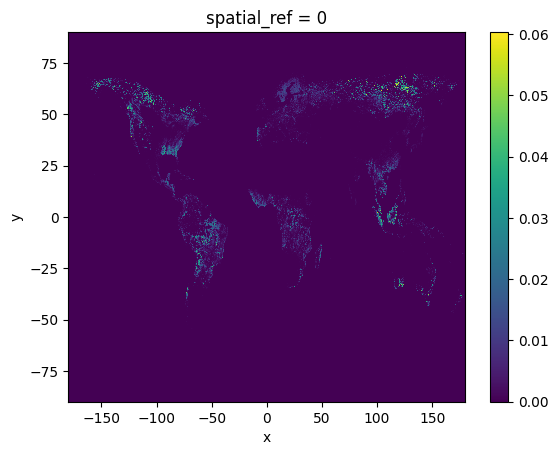

In [65]:
PCA.mean(dim='time').plot()

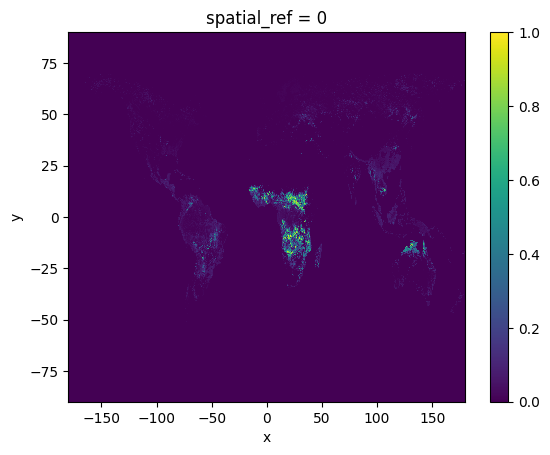

In [67]:
(disturbances.mean(dim='time')).plot()

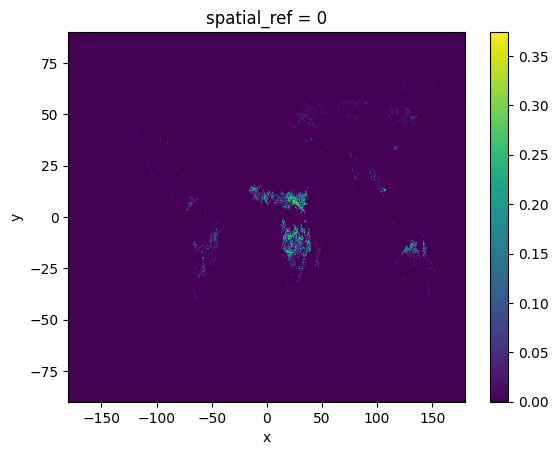

In [24]:
(PBA.mean(dim='time')*f_B).plot()
#+PCA+PBA

In [18]:
k2 = dist_map[0,:,:]*ds.sum(dim='landcover')*0.3
(100*k2*calc_area(k2)).sum(dim=['x','y'])/1e15

<xarray.DataArray (time: 20)> Size: 160B
array([5.77994729, 5.69923301, 5.69131133, 5.73976626, 5.74806611,
       5.7079602 , 5.74848513, 5.7758258 , 5.75969895, 5.68564598,
       5.65586512, 5.68184589, 5.62751704, 5.68742195, 5.71314452,
       5.74295128, 5.79711912, 5.75243247, 5.75326437, 5.72453393])
Coordinates:
  * time         (time) int64 160B 1993 1994 1995 1996 ... 2009 2010 2011 2012
    spatial_ref  int64 8B 0
    band         int64 8B ...

In [14]:
k = merged_100.sum(dim='landcover')
((100*k*calc_area(k)).sum(dim=['x','y']).diff(dim='time')/1e15).mean()

<xarray.DataArray ()> Size: 8B
array(0.86649326)
Coordinates:
    spatial_ref  int64 8B 0
    band         int64 8B 1

In [15]:
((100*ds.sum(dim='landcover')*calc_area(ds.sum(dim='landcover'))).sum(dim=['x','y']).diff(dim='time')/1e15).mean()

<xarray.DataArray ()> Size: 8B
array(-0.13538917)
Coordinates:
    spatial_ref  int64 8B 0
    band         int64 8B ...

In [ ]:
# (mask_h100_stocks + ds).sum(dim='landcover')[0,:,:].plot()
k = (intact_changes_disturbances.where(ds.sum(dim='landcover')>100)+ds).sum(dim='landcover')
(100*k*calc_area(k)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(2.1351845)
Coordinates:
    method                          <U15 60B 'AGC_ASC_DESCmax'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [97]:
k3 = mask_h100_stocks.sum(dim='landcover')
(100*k3*calc_area(k3)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(1.23672623)
Coordinates:
    method                          <U15 60B 'AGC_ASC_DESCmax'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [104]:
k = ds.where(~((ds.diff(dim='time').mean(dim='time')>0) & (ds.sum(dim='landcover')>100)),0)
k2 = k.sum(dim='landcover')
# (100*k2*calc_area(k2)).sum(dim=['x','y']).diff(dim='time').mean()/9e15
l = (mask_h100_stocks.sum(dim='landcover').fillna(0)+k2.fillna(0))#.plot(robust=True)
(100*l*calc_area(l)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(-2.29650105)
Coordinates:
    method                          <U15 60B 'AGC_ASC_DESCmax'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [82]:
k3 = mask_l100_stocks.sum(dim='landcover')
k3.rio.write_crs('EPSG:4326',inplace=True);
(100*k3*calc_area(k3)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(0.95467168)
Coordinates:
    method                          <U12 48B 'AGC_ASC_DESC'
    lambert_cylindrical_equal_area  int64 8B 0
    band                            int64 8B 1
    spatial_ref                     int64 8B 0

In [71]:
k = xr.where((ds.diff(dim='time').mean(dim='time')>0) & (ds.sum(dim='landcover')>100),0,ds)
k2 = (mask_h100_stocks.fillna(0) + k).sum(dim='landcover')
(100*k2*calc_area(k2)).sum(dim=['x','y']).diff(dim='time').mean()/9e15
# k.where(ds.diff(dim='time').mean(dim='time')>0).diff(dim='time')[1,:,:].plot()

<xarray.DataArray ()> Size: 8B
array(-1.00328109)
Coordinates:
    method                          <U12 48B 'AGC_ASC_DESC'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [55]:
# k2 = mask_h100_stocks + ds.where((ds.diff(dim='time')<=0).squeeze()) + mask_l100_stocks.fillna(0)
k2 = k2.sum(dim='landcover')
(100*k2*calc_area(k2)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(-0.70934782)
Coordinates:
    method                          <U12 48B 'AGC_ASC_DESC'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

In [45]:
k2 = (mask_h100_stocks.fillna(0) +  ds).sum(dim='landcover')
(100*k2*calc_area(k2)).sum(dim=['x','y']).diff(dim='time').mean()/9e15

<xarray.DataArray ()> Size: 8B
array(0.99612162)
Coordinates:
    method                          <U12 48B 'AGC_ASC_DESC'
    lambert_cylindrical_equal_area  int64 8B 0
    spatial_ref                     int64 8B 0
    band                            int64 8B 1

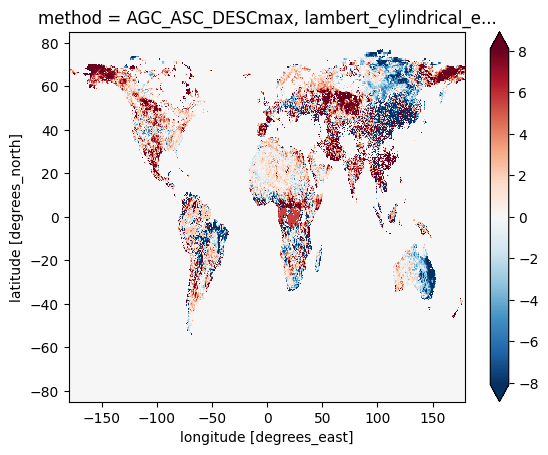

In [19]:
merged_200.sum(dim='landcover').diff(dim='time').plot(robust=True)

In [13]:
(100*ds*calc_area(ds)).sum(dim=['landcover','x','y']).diff(dim='time').mean()/1e15

<xarray.DataArray ()> Size: 8B
array(-0.1458043)
Coordinates:
    spatial_ref  int64 8B 0
    band         int64 8B ...

In [45]:
np.mean(k)/9e15

0.6951209209384009

In [44]:
k = []
for f in glob('../results/02_convert_AGB_TB/LVOD*.nc'):
    ds = xr.open_dataarray(f,decode_times=False)
    k.append((100*ds*calc_area(ds)).sum(dim=['landcover','x','y']).diff(dim='time').mean())

In [46]:
ds.close()

In [26]:
ds =xr.open_dataarray('../results/02_convert_AGB_TB/LVOD_xu_ma_TB.nc',decode_times=False)
ds_100,ds_200 = analyze_dataset(ds,growth_rate_map,disturbances)

In [7]:
# find the files that need to be processed
files =pd.Series(glob('../results/02_convert_AGB_TB/*.nc'))
files = files[files.str.contains('xu|liu|chen|LVOD')  & ~files.str.contains('_100|_200')].values
for file in tqdm(files):
    # load file
    ds =xr.open_dataarray(file,decode_times=False)

    # analyze file
    ds_100,ds_200 = analyze_dataset(ds,growth_rate_map,disturbances)
    print(file)
    
    # save results
    ds_100.to_netcdf(file[:-3] + '_100.nc')
    ds_200.to_netcdf(file[:-3] + '_200.nc')

  0%|          | 0/30 [00:00<?, ?it/s]

../results/02_convert_AGB_TB/LVOD_xu_huang_TB.nc


  3%|▎         | 1/30 [00:03<01:29,  3.09s/it]

../results/02_convert_AGB_TB/LVOD_song_huang_TB.nc


  7%|▋         | 2/30 [00:06<01:26,  3.09s/it]

../results/02_convert_AGB_TB/LVOD_CCI_huang_TB.nc


 10%|█         | 3/30 [00:09<01:23,  3.09s/it]

../results/02_convert_AGB_TB/LVODmax_xu_ma_TB.nc


 13%|█▎        | 4/30 [00:12<01:19,  3.05s/it]

../results/02_convert_AGB_TB/LVODmax_song_ma_TB.nc


 17%|█▋        | 5/30 [00:15<01:14,  2.97s/it]

../results/02_convert_AGB_TB/LVODmax_song_huang_TB.nc


 20%|██        | 6/30 [00:17<01:10,  2.92s/it]

../results/02_convert_AGB_TB/LVODmax_CCI_huang_TB.nc


 23%|██▎       | 7/30 [00:21<01:08,  2.98s/it]

../results/02_convert_AGB_TB/LVODmin_xu_huang_TB.nc


 27%|██▋       | 8/30 [00:23<01:03,  2.91s/it]

../results/02_convert_AGB_TB/LVODmin_song_huang_TB.nc


 30%|███       | 9/30 [00:26<01:01,  2.92s/it]

../results/02_convert_AGB_TB/LVODmin_CCI_huang_TB.nc


 33%|███▎      | 10/30 [00:29<00:58,  2.95s/it]

../results/02_convert_AGB_TB/liu_biomass_xu_ma_TB.nc


 37%|███▋      | 11/30 [00:42<01:54,  6.02s/it]

../results/02_convert_AGB_TB/liu_biomass_xu_huang_TB.nc


 40%|████      | 12/30 [00:55<02:22,  7.94s/it]

../results/02_convert_AGB_TB/liu_biomass_song_ma_TB.nc


 43%|████▎     | 13/30 [01:05<02:29,  8.80s/it]

../results/02_convert_AGB_TB/liu_biomass_song_huang_TB.nc


 47%|████▋     | 14/30 [01:17<02:33,  9.59s/it]

../results/02_convert_AGB_TB/liu_biomass_CCI_ma_TB.nc


 50%|█████     | 15/30 [01:29<02:36, 10.40s/it]

../results/02_convert_AGB_TB/liu_biomass_CCI_huang_TB.nc


 53%|█████▎    | 16/30 [01:41<02:30, 10.74s/it]

../results/02_convert_AGB_TB/xu_biomass_xu_TB.nc


 57%|█████▋    | 17/30 [02:24<04:28, 20.64s/it]

../results/02_convert_AGB_TB/xu_biomass_song_TB.nc


 60%|██████    | 18/30 [03:24<06:29, 32.44s/it]

../results/02_convert_AGB_TB/xu_biomass_CCI_TB.nc


 63%|██████▎   | 19/30 [04:20<07:12, 39.34s/it]

../results/02_convert_AGB_TB/chen_biomass_xu_TB.nc


 67%|██████▋   | 20/30 [04:22<04:42, 28.28s/it]

../results/02_convert_AGB_TB/chen_biomass_song_TB.nc


 70%|███████   | 21/30 [04:24<03:04, 20.53s/it]

../results/02_convert_AGB_TB/chen_biomass_CCI_TB.nc


 73%|███████▎  | 22/30 [04:27<02:00, 15.10s/it]

../results/02_convert_AGB_TB/LVOD_xu_ma_TB.nc


 77%|███████▋  | 23/30 [04:30<01:19, 11.39s/it]

../results/02_convert_AGB_TB/LVOD_song_ma_TB.nc


 80%|████████  | 24/30 [04:32<00:52,  8.79s/it]

../results/02_convert_AGB_TB/LVOD_CCI_ma_TB.nc


 83%|████████▎ | 25/30 [04:35<00:34,  6.91s/it]

../results/02_convert_AGB_TB/LVODmax_xu_huang_TB.nc


 87%|████████▋ | 26/30 [04:38<00:22,  5.64s/it]

../results/02_convert_AGB_TB/LVODmax_CCI_ma_TB.nc


 90%|█████████ | 27/30 [04:40<00:14,  4.69s/it]

../results/02_convert_AGB_TB/LVODmin_xu_ma_TB.nc


 93%|█████████▎| 28/30 [04:43<00:08,  4.04s/it]

../results/02_convert_AGB_TB/LVODmin_song_ma_TB.nc


 97%|█████████▋| 29/30 [04:45<00:03,  3.57s/it]

../results/02_convert_AGB_TB/LVODmin_CCI_ma_TB.nc


100%|██████████| 30/30 [04:48<00:00,  9.60s/it]
